<h3><center>Alexandra Almeida</center></h3> 
<h1><center>Project "Green Chillies Prices in India"</center></h1>
<img src="https://upskill.pt/wp-content/uploads/2020/03/cropped-APDC_UPSKILLS_Logo-300x83.png" width="200" align="center">

The present project was carried out under the Machine Learning module as part of the UpsKill program.

I have select a public dataset which contains a time list of chili peppers prices in India over 2048 days. The goal is to forecast prices for next 90 days.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
# import excel file and convert into pandas
df = pd.read_csv('Chillies Prices in India.csv', delimiter=';')
df.head()

,datesk,Item Name,Date,price
0,20110101,Chillies Green,01/01/2011,NaN
1,20110101,Chillies Bajji,01/01/2011,NaN
2,20110101,Chillies Cleaned,01/01/2011,NaN
3,20110101,Chillies small (C.B.P),01/01/2011,NaN
4,20110101,Chillies Bajji yagani,01/01/2011,NaN


In [3]:
# check dataframe'shape
df.shape

(13065, 4)

In [4]:
df = df[(df['Item Name']== 'Chillies Green')]
df.shape

(2613, 4)

In [5]:
#drop missing values
df.dropna(inplace=True)

In [6]:
# remove column datesk
df.drop(columns = ['datesk','Item Name'], inplace=True)

In [7]:
# remove rows where price is 0
df = df[~(df['price']== 0)]
df.reset_index(drop=True, inplace=True)
df.shape

(2048, 2)

In [8]:
# get the general descriptive statistics from data
df.describe()

,price
count,2048.000000
mean,35.721191
std,21.060151
min,16.000000
25%,25.000000
50%,30.000000
75%,40.000000
max,598.000000


In [22]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%y")
df.head()

ValueError: unconverted data remains: 13

After cleaning all columns and rows not needed, we can plot the data and visualize the prices evolution. We can see 2 data points where prices were much higher than usual.

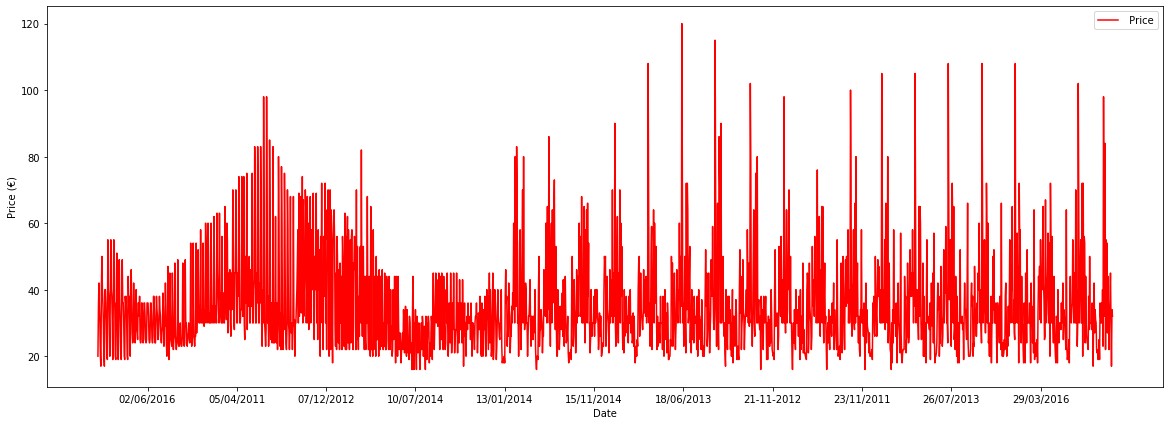

In [18]:
df.sort_values(by=['Date'], ascending = True, inplace = True)

# creating a pot in order to visualize the price evolution.
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],180))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()

In [10]:
# sort the dataframe by descending price in order to find the 2 outlier prices
df.sort_values(by=['price'], ascending=False)

,Date,price
1592,15/07/2016,598.0
1574,22/06/2016,441.0
1544,18/05/2016,120.0
1545,19/05/2016,115.0
1551,26/05/2016,108.0
...,...,...
1649,10/07/2016,16.0
1648,10/06/2016,16.0
1638,22/09/2016,16.0
1639,24/09/2016,16.0


In [11]:
outliers = df.index[[1574,1592]]
df.drop(outliers, inplace=True)

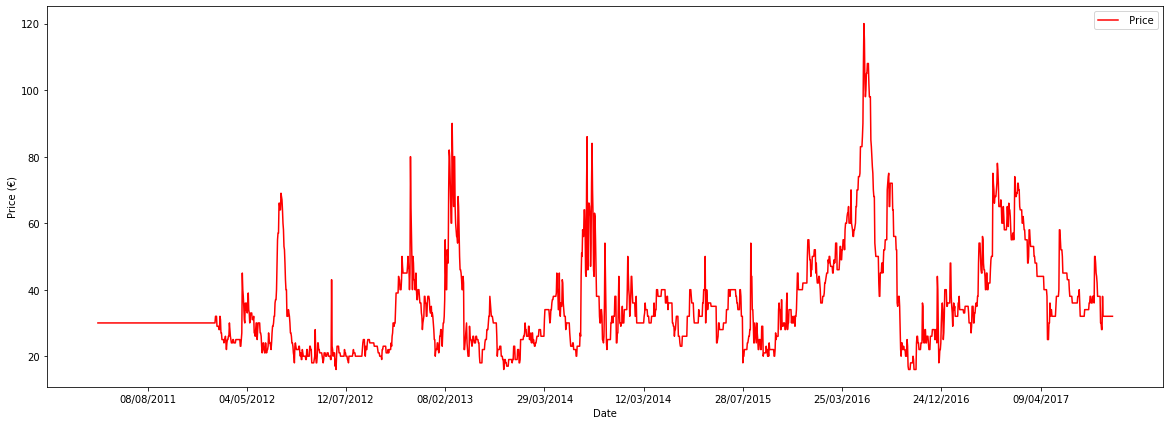

In [12]:
plt.figure(figsize=(20,7))
plt.plot(df['Date'].values, df['price'].values, label = ' Price', color = 'red')
plt.xticks(np.arange(100,df.shape[0],200))
plt.xlabel('Date')
plt.ylabel('Price (€)')
plt.legend()
plt.show()